In [1]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime

import niskine
import mplniw.plot as pl
import gvpy as gv
import mplniw.sigp as sp
import mplniw.utils as ut

In [43]:
conf = niskine.io.load_config()
lon, lat, bottom_depth = niskine.io.mooring_location(mooring=1)
root_dir = '/Users/zcasparcohen/codes/NIW/'
figdir = '/Users/zcasparcohen/Documents/Figures/'

In [3]:
mooring=1
wind_work = xr.open_dataset(root_dir+'data/wind_work/ni_wind_work_niskine_m1.nc')
wind_stress = xr.open_dataset(root_dir+'data/wind_work/wind_stress_niskine_m1.nc')
gridded = xr.open_dataset(root_dir+'data/gridded/M%s_gridded_simple_merge_gaps_filled.nc'%mooring)
filtered = xr.open_dataset('/Users/zcasparcohen/Documents/NISKINE/data/filtered_convolve.nc')
#wind_work = xr.open_mfdataset(conf.data.wind_work,parallel=True)

In [4]:
ds_filtered = sp.ni_bandpass_adcp(gridded)
ds_filt,wkb = sp.calc_ni_eke(ds_filtered)
ds_filt


<xarray.Dataset>
Dimensions:       (z: 106, time: 72966, adcp: 3)
Coordinates:
  * time          (time) datetime64[ns] 2019-05-17T16:00:00 ... 2020-10-05T08...
  * z             (z) int64 0 16 32 48 64 80 ... 1600 1616 1632 1648 1664 1680
  * adcp          (adcp) int64 3109 9408 13481
Data variables:
    u             (z, time) float64 ...
    v             (z, time) float64 ...
    xducer_depth  (adcp, time) float64 ...
    temperature   (adcp, time) float64 ...
    bpu           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    bpv           (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    n2            (z, time) float64 2.251e-06 2.251e-06 ... 1.244e-06 1.244e-06
    N             (z, time) float64 0.0015 0.0015 0.0015 ... 0.001115 0.001115
    ni_eke        (z, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    project:       NISKINe
    mooring:       M1
    lon:           -21.198829621395166
    lat:           59.101445324829214
    bottom_depth:  2881.0

In [14]:
ds_filt['ke'] = 0.5*(ds_filt.u**2+ds_filt.v**2)
ds_filt['eke'] = 0.5*((ds_filt.u-ds_filt.u.mean())**2+(ds_filt.v-ds_filt.v.mean())**2)
ds_filt['bpu_wkb'] = ds_filt['bpu']*wkb
ds_filt['bpv_wkb'] = ds_filt['bpv']*wkb
ds_filt.ni_eke.attrs.update({'long_name':'Kinetic energy', 'units':r'$m^2.s^{-2}$'})
ds_filt.bpu_wkb.attrs.update({'long_name':'Zonal velocity', 'units':r'$m.s^{-1}$'})
ds_filt.bpv_wkb.attrs.update({'long_name':'Meridional velocity', 'units':r'$m.s^{-1}$'})

In [6]:
filtered = filtered.sel(time=ds_filt.time,z=ds_filt.z)
filtered['bpu_wkb'] = filtered.u_ni*wkb
filtered['bpv_wkb'] = filtered.v_ni*wkb
filtered['ni_eke'] = 0.5*(filtered.bpu_wkb**2+filtered.bpv_wkb**2)

In [8]:
#MLD loading
mld_all = xr.open_dataset(conf.data.input.argo_mld)
mld_da = xr.DataArray(data=mld_all.mld_da_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='da')
mld_dt = xr.DataArray(data=mld_all.mld_dt_mean.data, coords=dict(lon=mld_all.lon.data, lat=mld_all.lat.data, month=mld_all.month.data), dims=('lat', 'lon', 'month'), name='dt')


In [9]:
#Local MLD
mld = mld_da.sel(lon=lon,lat=lat,method='nearest')

In [10]:
mld_m1 = xr.open_dataarray(conf.data.ml.mld)
mld_m1_argo = xr.open_dataset(conf.data.ml.mld_argo).interp(lon=lon,lat=lat)

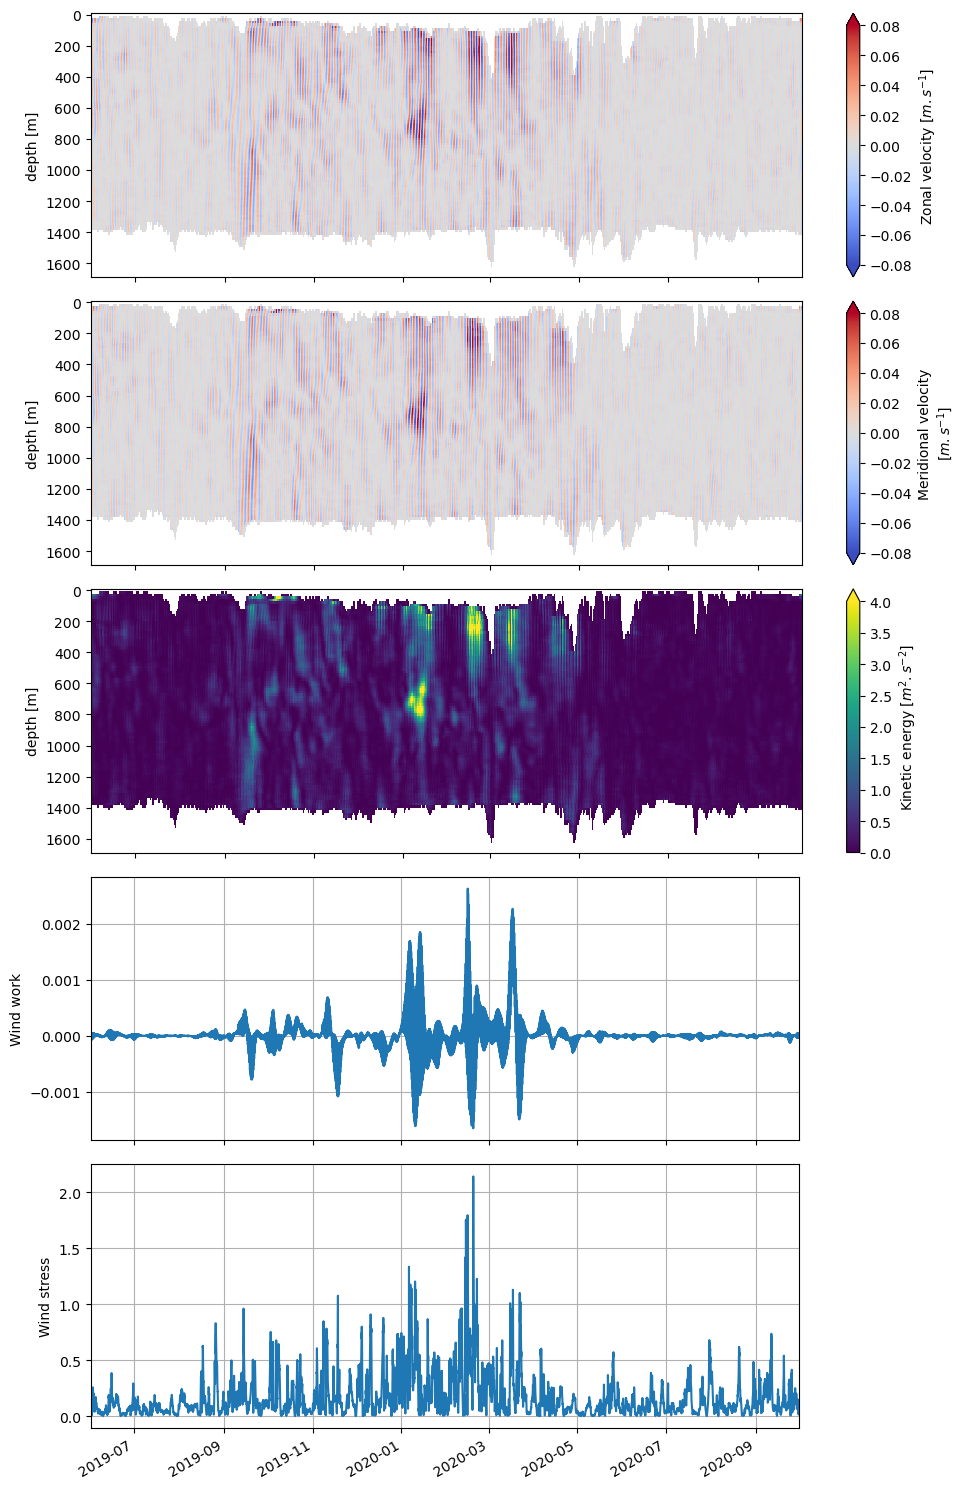

In [46]:
fig = plt.figure(tight_layout=True,figsize=(10,15))
gs = gridspec.GridSpec(5,5)
ax = fig.add_subplot(gs[2,:])
ds_filt.ni_eke.plot(ax=ax,y='z',yincrease=False,vmax=4)
ticks = ax.get_xticks()
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-10-01'))
ax.tick_params(labelbottom=False);ax.set_xlabel('');
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-10-01'))
ax = fig.add_subplot(gs[0,:])
ds_filt.bpu_wkb.plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
ax.tick_params(labelbottom=False);ax.set_xlabel('')
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-10-01'))
ax = fig.add_subplot(gs[1,:])
ds_filt.bpv_wkb.plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
ax.tick_params(labelbottom=False);ax.set_xlabel('')
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-10-01'))
ax = fig.add_subplot(gs[3,:-1])
wind_work['NISKINE M1 mode1 wind-work'].plot(ax=ax)
ax.tick_params(labelbottom=False);ax.set_title('');ax.set_ylabel('Wind work')
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-10-01'))
ax.grid();
ax = fig.add_subplot(gs[4,:-1])
wind_stress.__xarray_dataarray_variable__.plot(ax=ax)
ax.set_xlim(np.datetime64('2019-06-01'),np.datetime64('2020-10-01'))
ax.set_ylabel('Wind stress');ax.set_title('');ax.grid();
fig.savefig(figdir+'M1_events.png')

In [47]:
# Defining events ("a la main"):
ti = ['2019-11-09T02:00:00.000000000','2020-01-03T01:00:00.000000000',
      '2020-02-13T02:00:00.000000000','2020-03-08T12:00:00.000000000']
tf = ['2019-11-22T09:00:00.000000000','2020-01-19T14:00:00.000000000',
      '2020-02-26T19:00:00.000000000','2020-03-25T04:00:00.000000000']
months=[11,1,2,3]

### Describing velocities and energy around 4 different wind events and their link to MLD and wind work

In [64]:
mld_m1_argo

<xarray.Dataset>
Dimensions:  (month: 12)
Coordinates:
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
    lon      float64 -21.2
    lat      float64 59.1
Data variables:
    dt       (month) float64 349.9 392.7 535.2 256.5 ... 46.35 77.74 125.5 272.7
    da       (month) float64 229.0 313.1 439.5 175.3 ... 42.34 75.09 109.9 250.5
    da_m1    (month) float64 229.0 313.1 439.5 175.3 ... 42.34 75.09 109.9 250.5
    dt_m1    (month) float64 349.9 392.7 535.2 256.5 ... 46.35 77.74 125.5 272.7

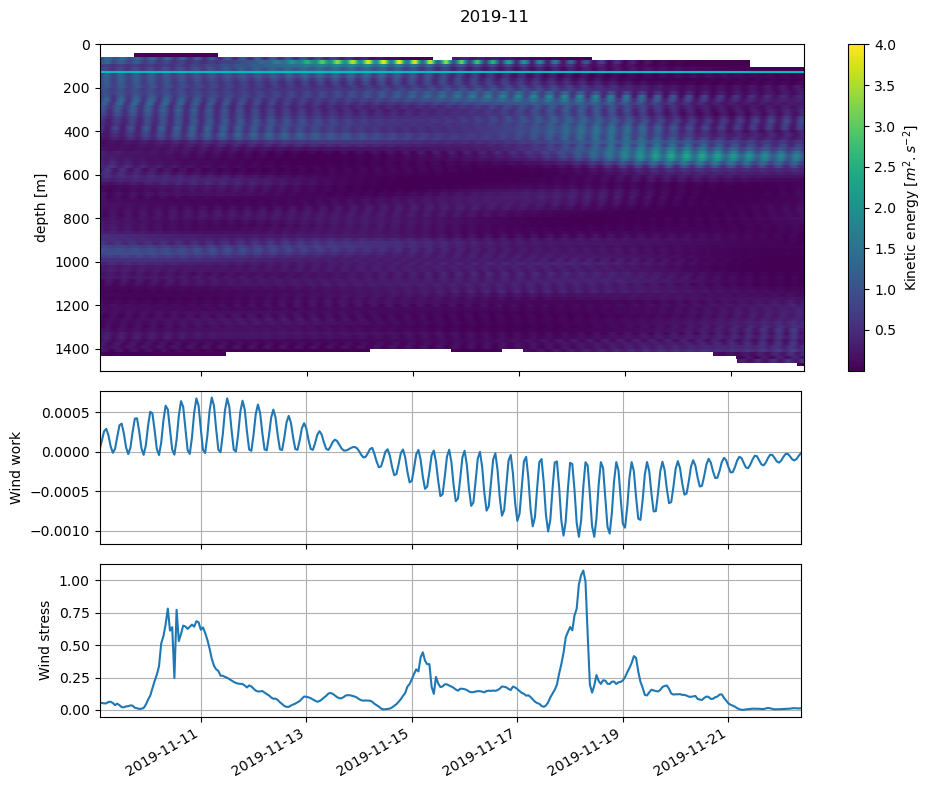

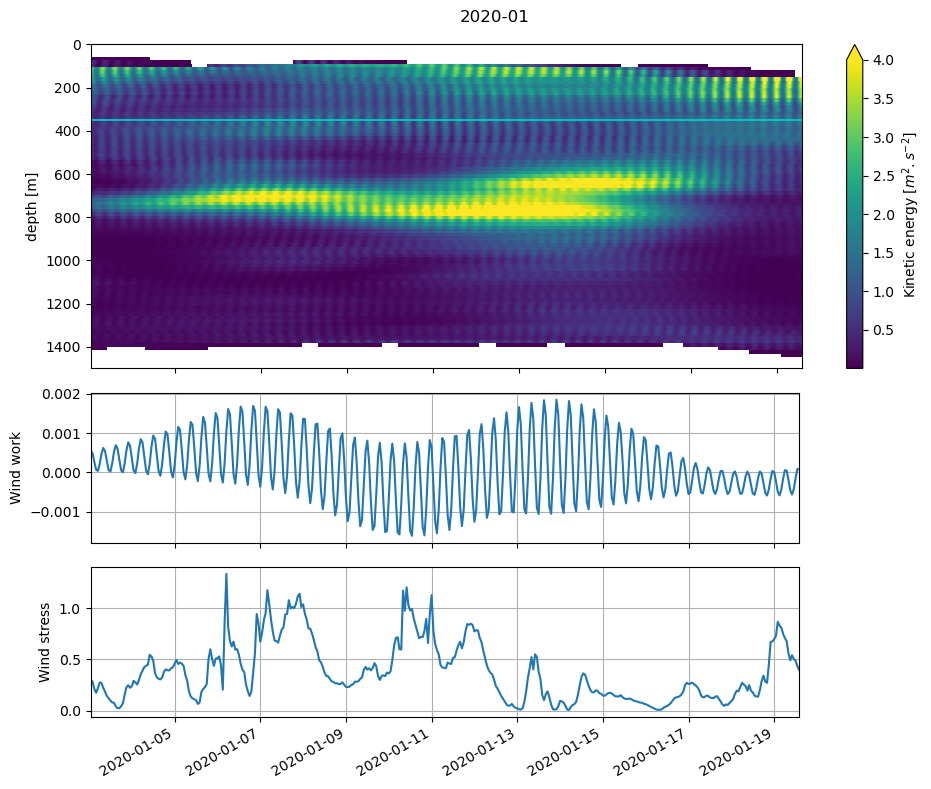

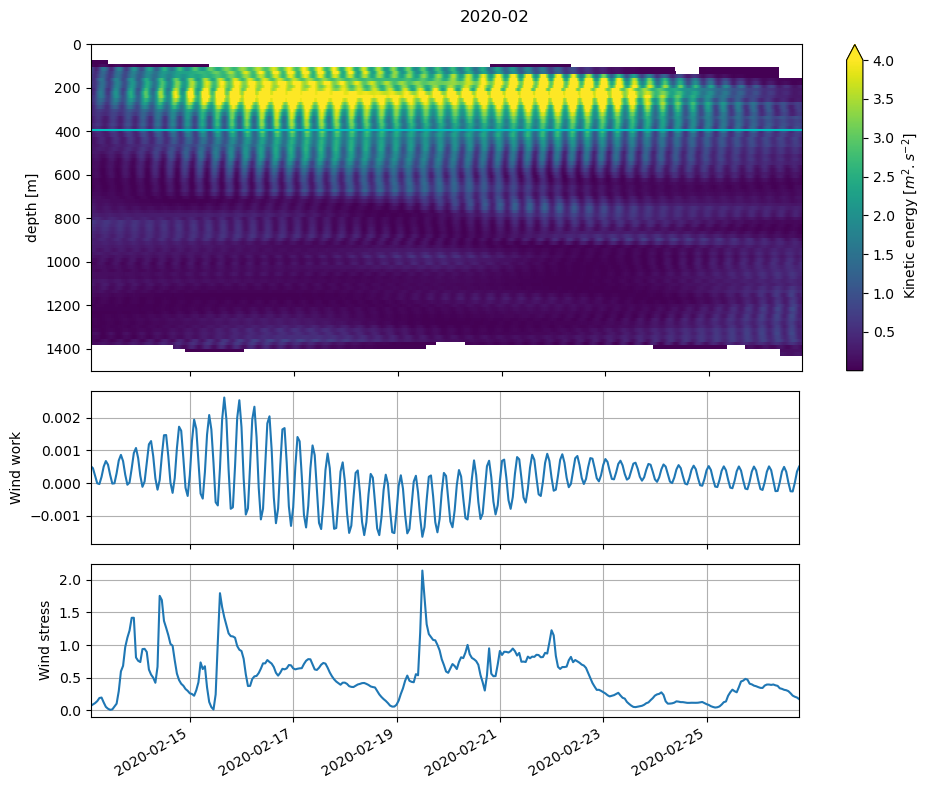

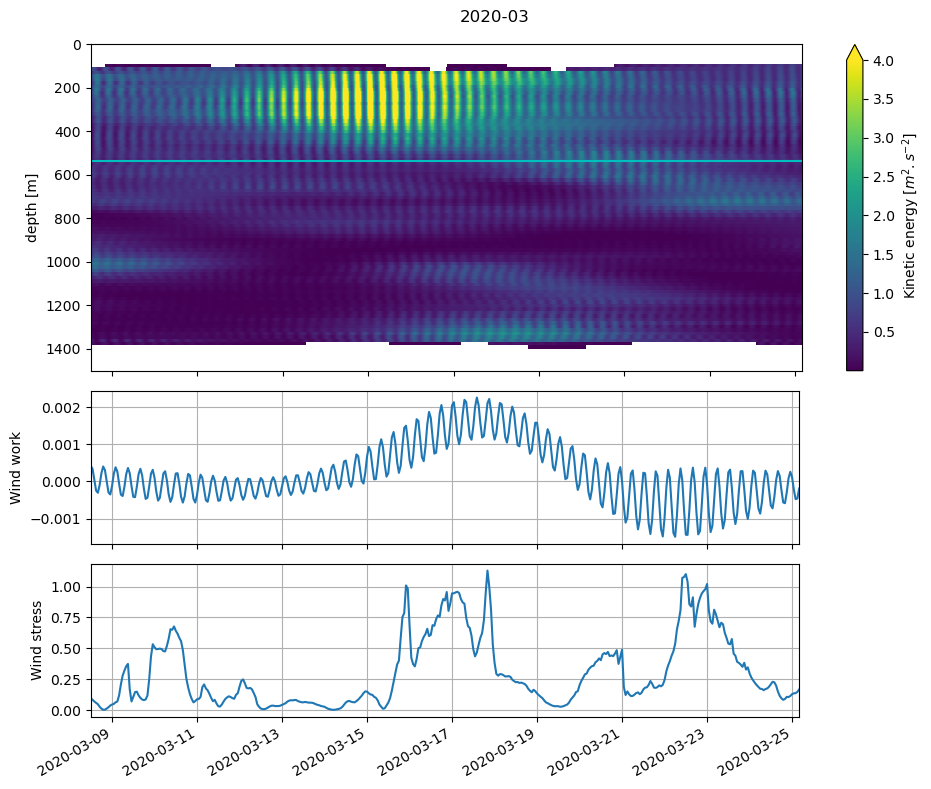

In [67]:
for index in range(len(ti)):
    _time = ds_filt.sel(time=slice(ti[index],tf[index])).time
    fig = plt.figure(tight_layout=True,figsize=(10,8))
    gs = gridspec.GridSpec(4,5)
    ax = fig.add_subplot(gs[0:2,:])
    ds_filt.ni_eke.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=4)
    ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(np.datetime64(ti[index]),np.datetime64(tf[index]));
    ax.set_ylim(1500,0);
    ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5)
    #ax = fig.add_subplot(gs[0,:])
    #ds_filt.bpu_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
    #ax.tick_params(labelbottom=False);ax.set_xlabel('')
    #ax.set_xlim(ti[index],tf[index])
    #ax = fig.add_subplot(gs[1,:])
    #ds_filt.bpv_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
    #ax.tick_params(labelbottom=False);ax.set_xlabel('')
    #ax.set_xlim(ti[index],tf[index])
    ax = fig.add_subplot(gs[2,:-1])
    wind_work['NISKINE M1 mode1 wind-work'].sel(time=_time,method='nearest').plot(ax=ax)
    ax.tick_params(labelbottom=False);ax.set_title('');ax.set_ylabel('Wind work')
    ax.set_xlim(np.datetime64(ti[index]),np.datetime64(tf[index]))
    ax.grid();
    ax = fig.add_subplot(gs[3,:-1])
    wind_stress.__xarray_dataarray_variable__.sel(time=_time,method='nearest').plot(ax=ax)
    ax.set_xlim(np.datetime64(ti[index]),np.datetime64(tf[index]))
    ax.set_ylabel('Wind stress');ax.set_title('');ax.grid();
    fig.suptitle(ti[index][:7])
    fig.savefig(figdir+'M1_event%s.png'%index)

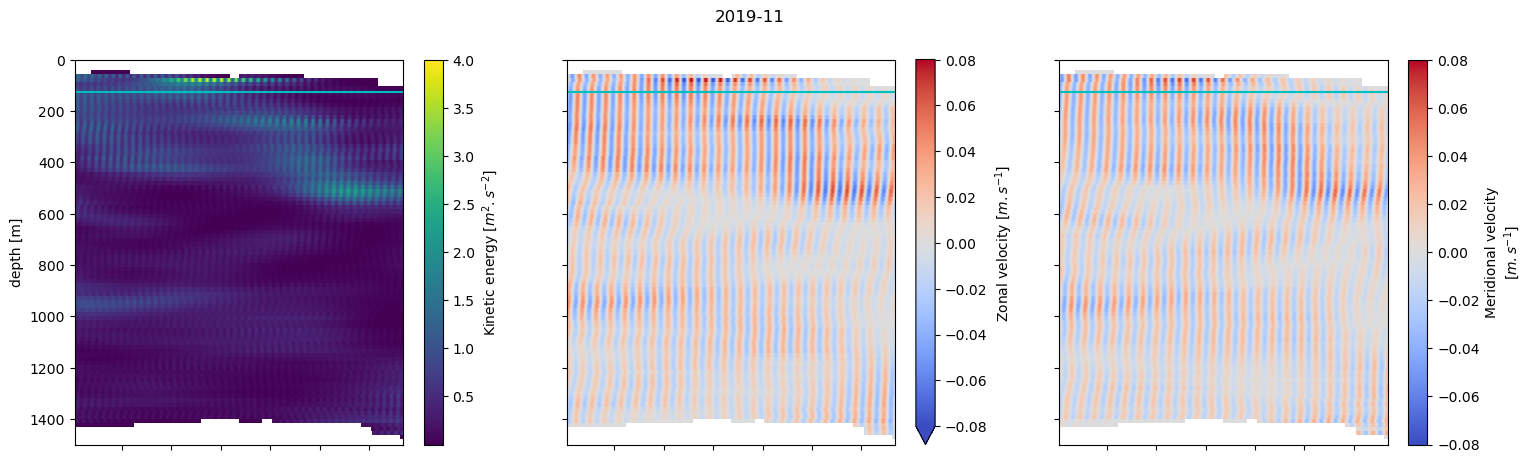

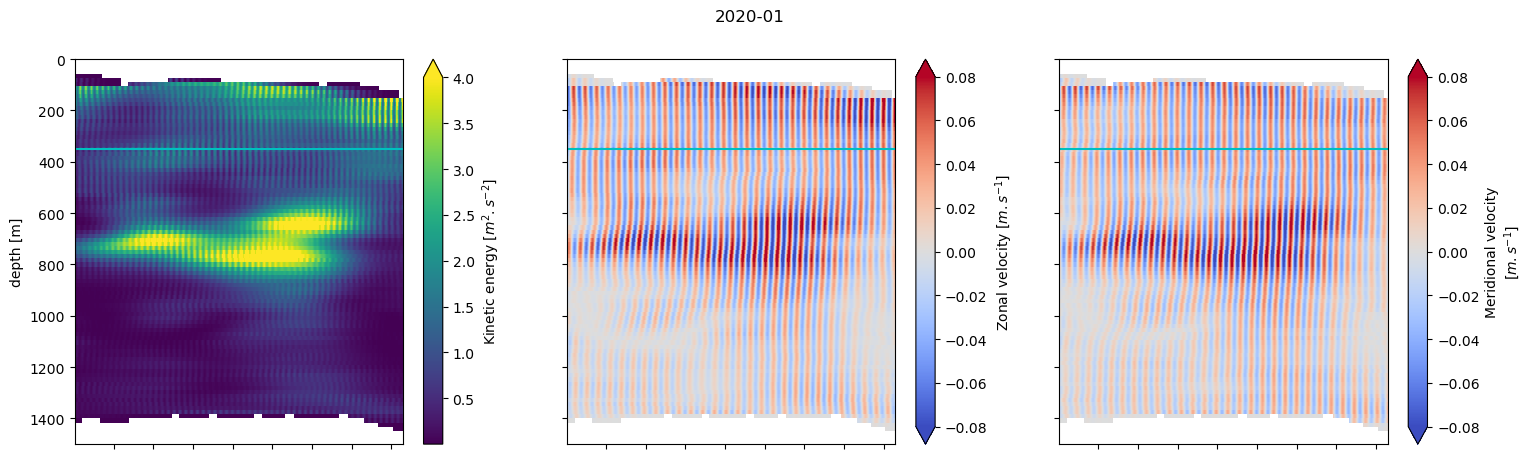

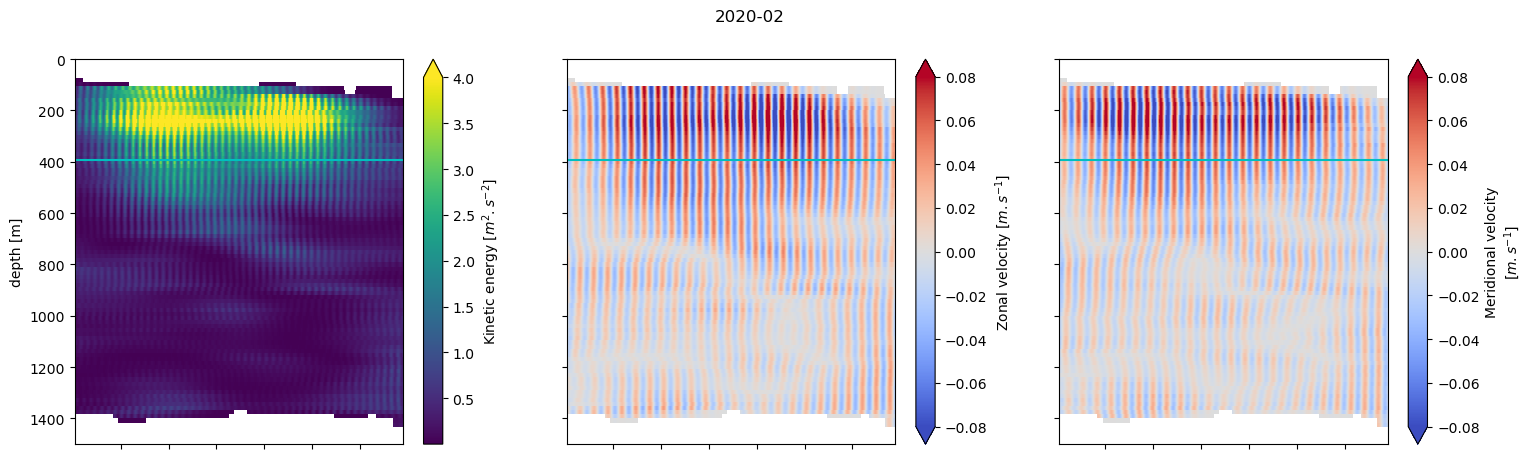

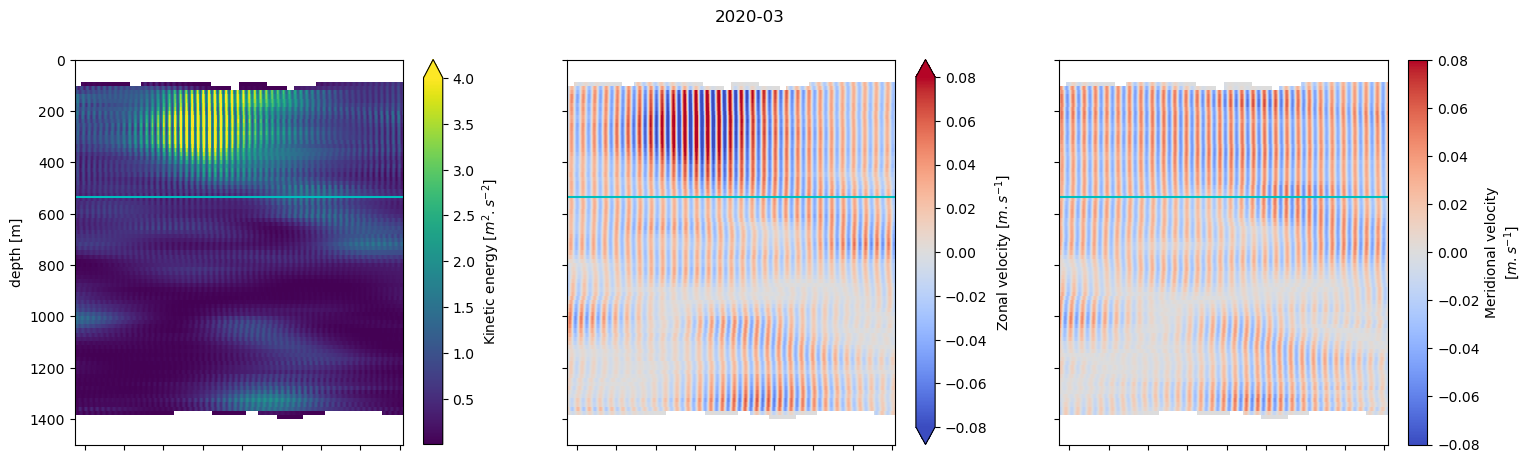

In [79]:
for index in range(len(ti)):
    _time = ds_filt.sel(time=slice(ti[index],tf[index])).time
    fig,axs = plt.subplots(1,3,figsize=(18,5))
    ax=axs[0]
    ds_filt.ni_eke.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=4)
    ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(np.datetime64(ti[index]),np.datetime64(tf[index]));
    ax.set_ylim(1500,0);
    ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5)

    ax=axs[1]
    ds_filt.bpu_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
    ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(np.datetime64(ti[index]),np.datetime64(tf[index]));
    ax.set_ylim(1500,0);
    ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5)
    ax.tick_params(labelleft=False);ax.set_ylabel('')
    ax=axs[2]
    ds_filt.bpv_wkb.sel(time=_time).plot(ax=ax,y='z',yincrease=False,vmax=0.08,cmap='coolwarm')
    ax.tick_params(labelbottom=False);ax.set_xlabel('');
    ax.set_xlim(np.datetime64(ti[index]),np.datetime64(tf[index]));
    ax.set_ylim(1500,0);
    ax.axhline(mld_m1_argo.dt_m1.sel(month=months[index]),c='c',ls='-',lw=1.5);
    ax.tick_params(labelleft=False);ax.set_ylabel('')
    fig.suptitle(ti[index][:7])
    fig.savefig(figdir+'M1_event%s_uv.png'%index)

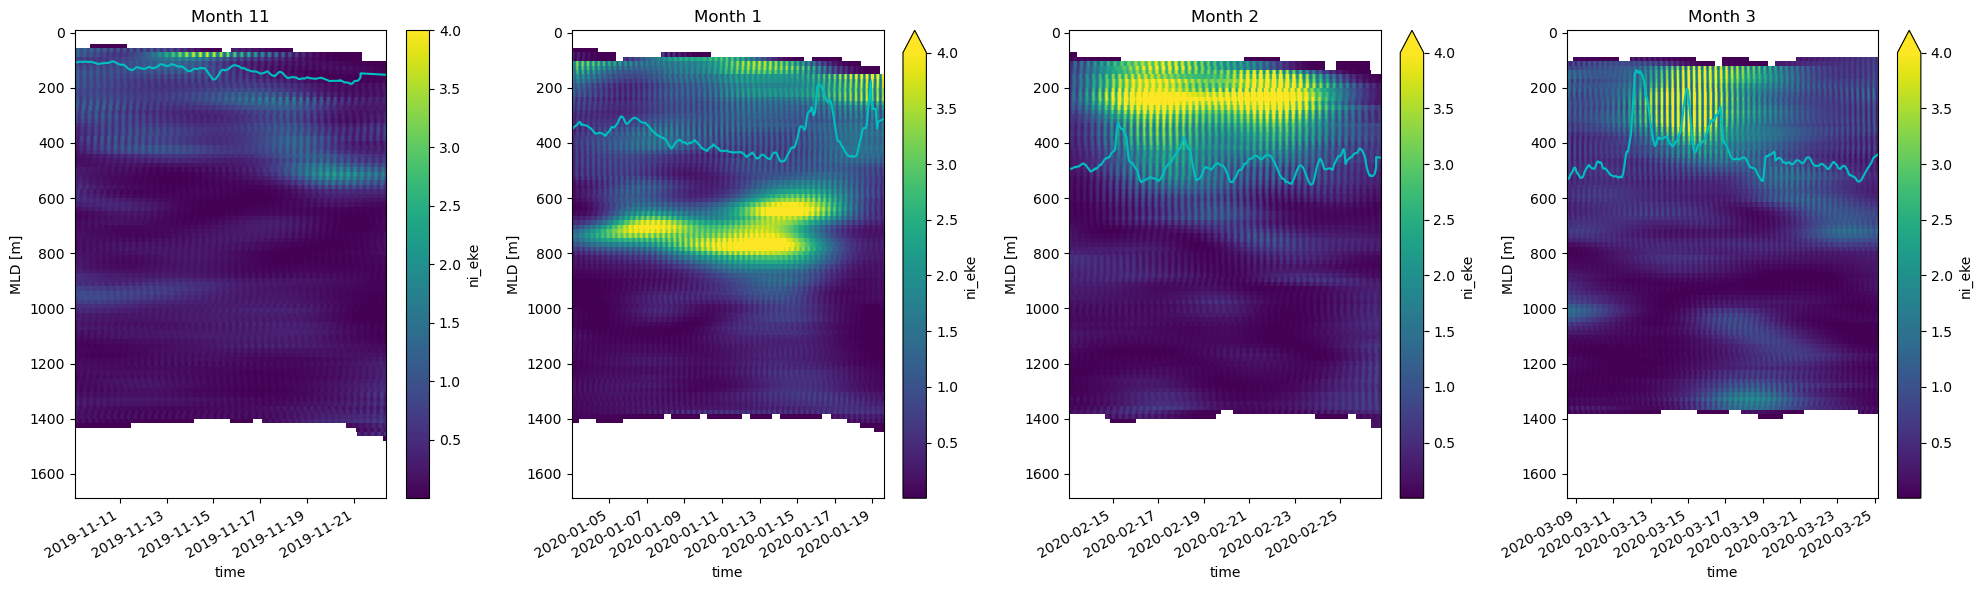

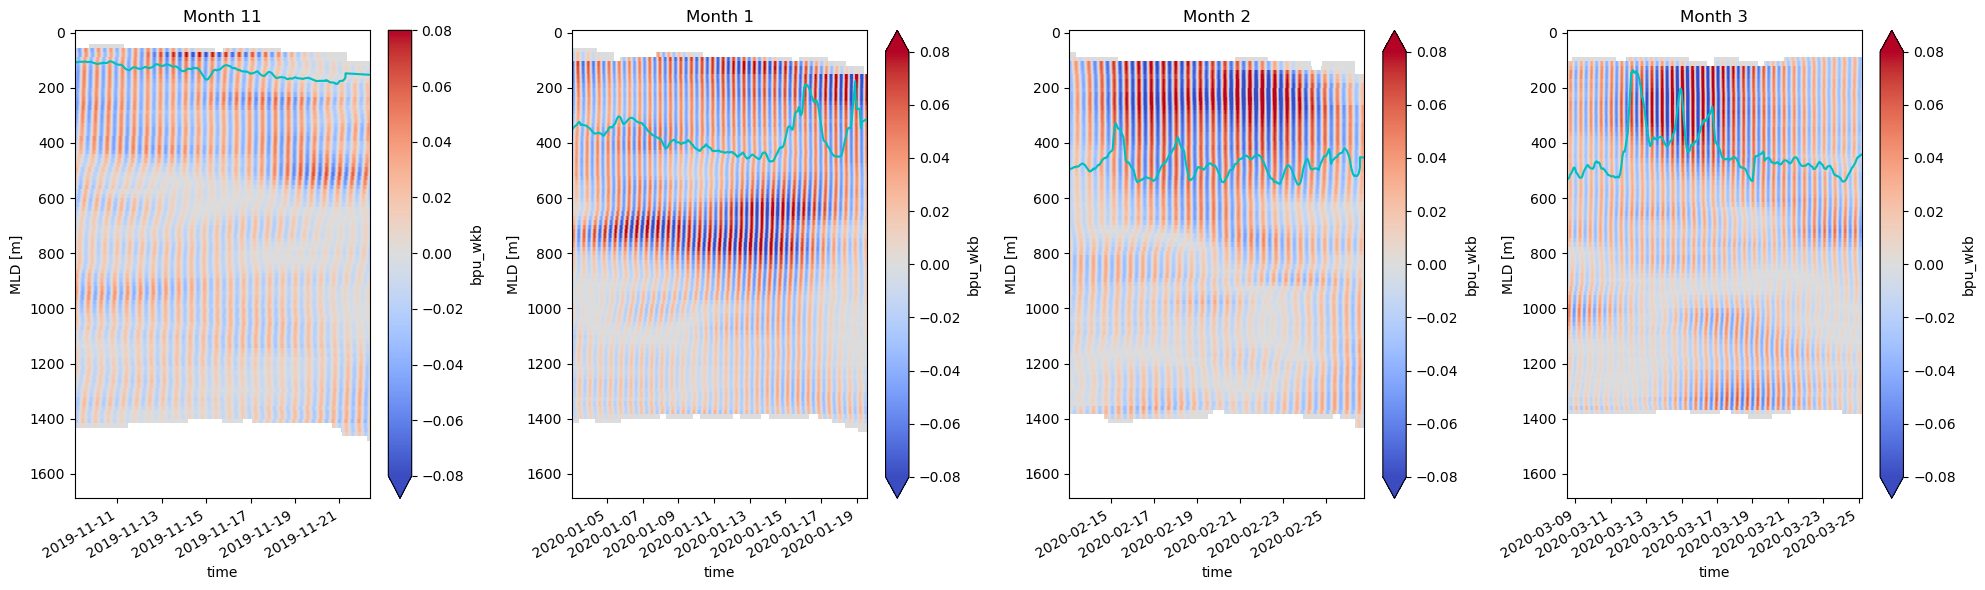

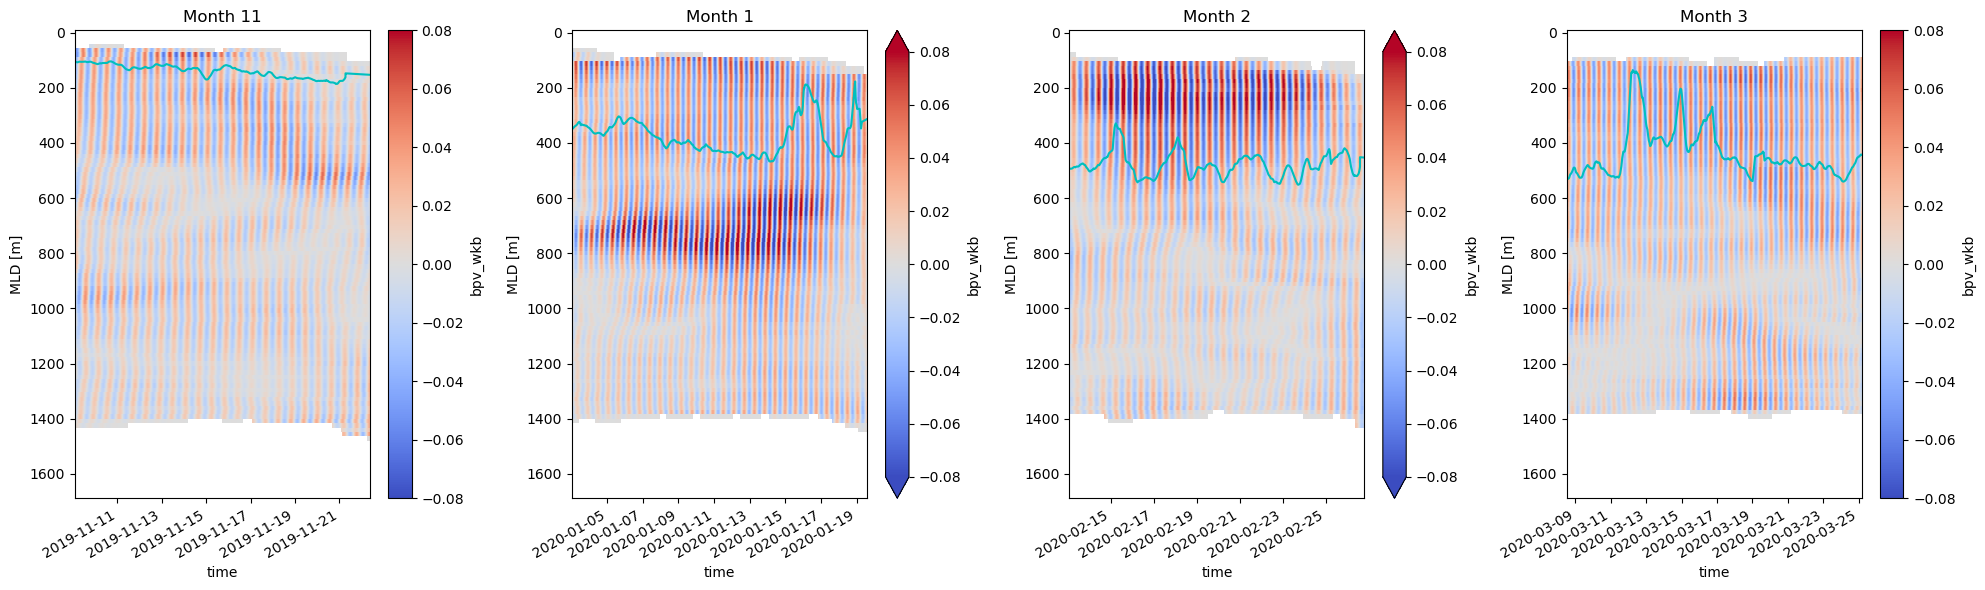

In [13]:
#NI EKE
fig,ax = pl.plot_event2D(ds_filt,'ni_eke',mld_m1,ti,tf,months,**{'vmax':4})
fig.tight_layout()
#NI u
fig,ax = pl.plot_event2D(ds_filt,'bpu_wkb',mld_m1,ti,tf,months,**{'cmap':'coolwarm','vmax':0.08})
fig.tight_layout()
#NI v
fig,ax = pl.plot_event2D(ds_filt,'bpv_wkb',mld_m1,ti,tf,months,**{'cmap':'coolwarm','vmax':0.08})
fig.tight_layout()

In [ ]:
#NI EKE
fig,ax = plot_event2D(ds_filt,'ni_eke',ti,tf,months,**{'vmax':4})
fig.tight_layout()
#NI u
fig,ax = plot_event2D(ds_filt,'bpu_wkb',ti,tf,months,**{'cmap':'coolwarm','vmax':0.08})
fig.tight_layout()
#NI v
fig,ax = plot_event2D(ds_filt,'bpv_wkb',ti,tf,months,**{'cmap':'coolwarm','vmax':0.08})
fig.tight_layout()

In [20]:
index=2
_time = ds_filt.sel(time=slice(ti[index],tf[index])).time

In [21]:
for i,t in enumerate(_time[:]):
    fig = plt.figure(tight_layout=True,figsize=(5,8))
    gs = gridspec.GridSpec(3,2)
    ax0 = fig.add_subplot(gs[2,:])
    ax0.axvline(t.values,c='k')
    wind_work['NISKINE M1 mode1 wind-work'].sel(time=_time,method='nearest').plot(ax=ax0,zorder=-1);
    ax0.grid();ax0.set_title('');ax0.set_xlabel('time');ax0.set_ylabel('Wind work')
    #ax0.tick_params(bottom=False,labelbottom=False)
    #fig,ax = plt.subplots(1,2,figsize=(10,5))
    for j,v in enumerate(['bpu_wkb','bpv_wkb']):
        ax = fig.add_subplot(gs[:2,j])
        ds_filt.sel(time=t,z=slice(100,None))[v].plot(ax=ax,y='z',yincrease=False,zorder=1,
                                                      xlim=(ds_filt.bpu_wkb.min(),ds_filt.bpu_wkb.max()),ylim=(1500,0))
    #ds_filt.sel(time=t,z=slice(100,None)).bpv_wkb.plot(ax=ax[1],y='z',yincrease=False,zorder=1);
        #ax.axhline(mld.sel(month=months[index]),ls='--',lw=1.5,c='k',zorder=-1)
        ax.axhline(mld_m1.sel(time=t, method='nearest'),ls='--',lw=1.5,c='k',zorder=-1)
        #.plot(ax=ax,x='time',c='k',zorder=-1) 
        ax.grid();ax.set_title('');ax.set_xlabel('');ax.set_title(v[2]+r'$_{wkb}$ [m/s]')
    ax.tick_params(left=False,labelleft=False);ax.set_ylabel('');
    fig.suptitle(datetime.utcfromtimestamp(t.values.astype(int) * 1e-9).strftime('%m/%d/%Y, %H:%M:%S'),x=0.6)
    #plt.show();
    fig.savefig(root_dir+'Figures/event%s_time%s.png'%(index,i));
    fig.clear()
    plt.close(fig)

In [ ]:
for i,t in enumerate(_time[:]):
    fig,ax = plt.subplots(figsize=(5,5))
    ds_filt.sel(time=t).ni_eke.plot(ax=ax,y='z',yincrease=False,zorder=1)
    ax.set_xlim(ds_filt.ni_eke.min(),ds_filt.ni_eke.max());
        a.set_ylim(1500,0);
        a.axhline(mld.sel(month=months[index]),ls='--',lw=1.5,c='k',zorder=-1)
        a.grid();
    plt.show();
    fig.savefig(root_dir+'Figures/event%s_time%s.png'%(index,i));
    plt.close(fig);

In [160]:
import matplotlib.pylab as plb
n = len(ti)
colors = plb.cm.Blues_r(np.linspace(0,0.7,n))

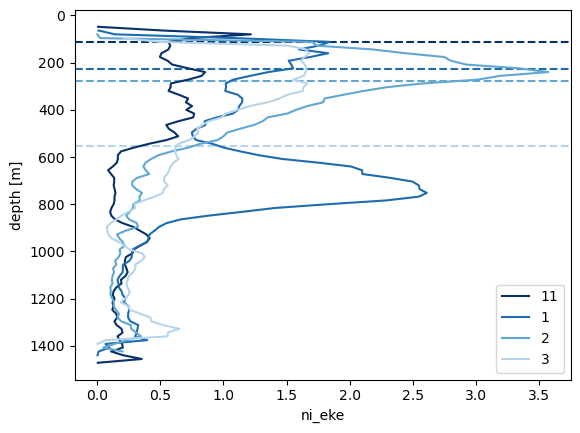

In [161]:
fig,ax = plt.subplots()
for i in range(len(ti)):
    ds_filt.sel(time=slice(ti[i],tf[i])).ni_eke.mean('time').plot(ax=ax,y='z',yincrease=False,label=str(months[i]),
                                                                  c=colors[i],zorder=1)
    ax.axhline(mld.sel(month=months[i]),c=colors[i],zorder=-1,ls='--')
ax.legend();#ax.grid();

#### Notes:
A bit messy in the current state, should be better with selecting three events max

In [169]:
index=3
_time = ds_filt.sel(time=slice(ti[index],tf[index])).time

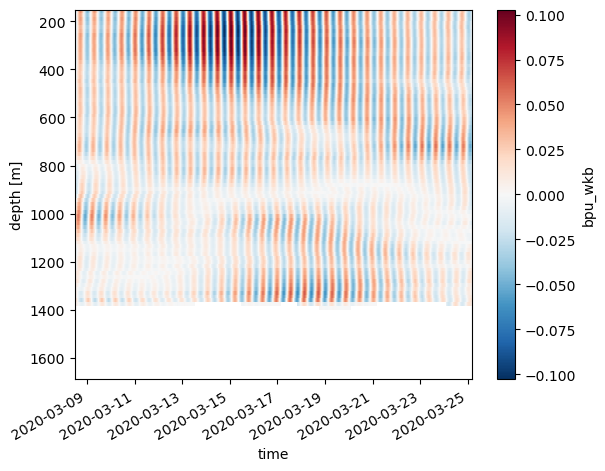

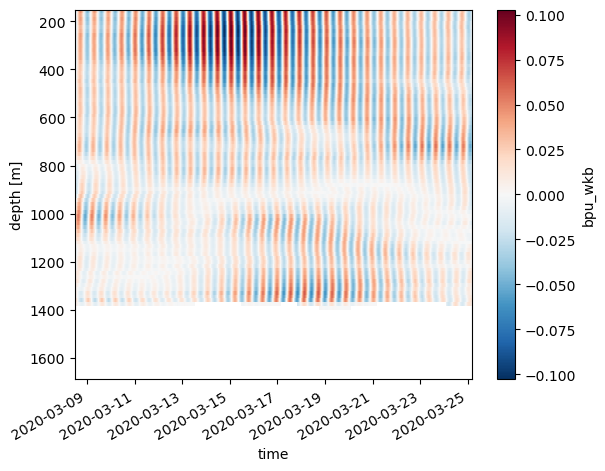

In [180]:
mean_prof = ds_filt.sel(z=slice(150,None)).bpu_wkb.mean('time')

(ds_filt.sel(time=_time,z=slice(150,None)).bpu_wkb-mean_prof).plot(y='z',yincrease=False)
plt.figure()
(ds_filt.sel(time=_time,z=slice(150,None)).bpu_wkb).plot(y='z',yincrease=False)

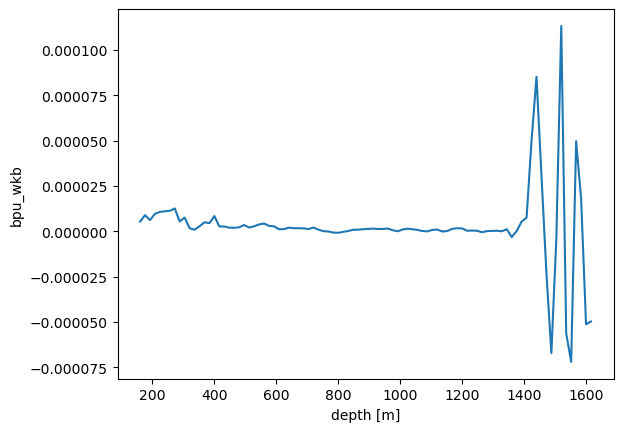

In [182]:
mean_prof.plot()

In [166]:
wind_bin = [wind_work['NISKINE M1 mode1 wind-work'].sel(time=slice(ti[i],tf[i])).mean() for i in range(len(ti))]
mld_bin = [mld.sel(month=months[i]) for i in range(len(ti))]
eke_bin = [ds_filt['ni_eke'].sel(time=slice(ti[i],tf[i])).mean()*100 for i in range(len(ti))]

In [167]:
from matplotlib.lines import Line2D
custom = [Line2D([], [], marker='.', markersize=eke_bin[i]//10, color=colors[i], linestyle='None') for i in range(len(ti))]

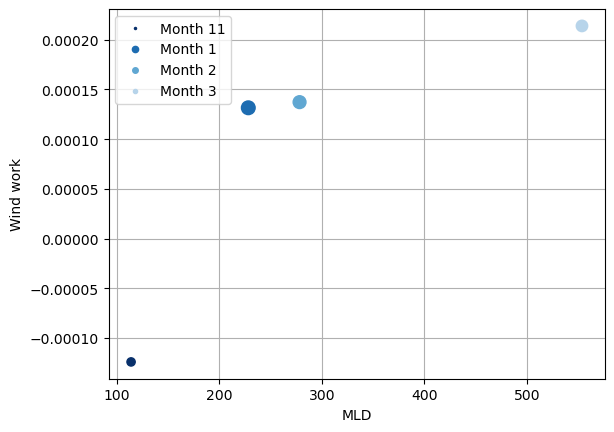

In [168]:
fig,ax = plt.subplots()
scatter = ax.scatter(x=mld_bin,y=wind_bin,s=eke_bin,c=colors)
ax.set_ylabel('Wind work');ax.set_xlabel('MLD');
ax.grid();
ax.legend(handles = custom,labels=['Month '+ str(months[i]) for i in range(len(ti))])
#ax.legend(['Month '+ str(months[i]) for i in range(len(ti))])

#### Notes:
Exemple of summary figure for all wind events detected at all morrings.
Color correspond to the month, size to the NIkinetic energy

#### Test cells

In [ ]:
_ = filtered.sel(time='2020-02-13T09:50:00')
_filt = ds_filt.sel(time='2020-02-13T10:00:00')
_s = filtered.sel(time='2020-02-13T10:00:00')

In [ ]:
#_.u_ni.plot()
#_.bpu_wkb.plot()
_filt.sel(z=slice(100,None)).bpu_wkb.plot()
#_.u.plot()

plt.figure()
_s.u_ni.plot()
_s.bpu_wkb.plot()
_s.u.plot()

In [ ]:
from matplotlib.animation import FuncAnimation
def animation_func(t):
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_filt.sel(time=t).bpu_wkb.plot(ax=ax[0],y='z',yincrease=False,zorder=1)
    ds_filt.sel(time=t).bpv_wkb.plot(ax=ax[1],y='z',yincrease=False,zorder=1)
    for a in ax:
        a.set_xlim(ds_filt.bpu_wkb.min(),ds_filt.bpu_wkb.max());
        a.set_ylim(1500,0);
        a.axhline(mld.sel(month=months[index]),ls='--',lw=1.5,c='k',zorder=-1)
        a.grid();
    plt.show();
    plt.close(fig);
    

In [ ]:
animation = FuncAnimation(fig, animation_func,frames=_time)
animation.save(root_dir+'animations/event1_uv.mp4')